In [28]:
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import numpy as np, scipy as sp, scipy.stats, os, sys, joblib
import os, numpy as np, scipy as sp, scipy.io, scipy.io.wavfile
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.utils import class_weight
import datetime
import random
import pandas as pd
import importlib
import useful_functions
import preprocessing_functions
import Chatgpt_model
import metrics_loss_functions
import models
import results_functions
importlib.reload(results_functions)
importlib.reload(models)
importlib.reload(metrics_loss_functions)
from results_functions import *
from models import *

from metrics_loss_functions import *
importlib.reload(useful_functions)
importlib.reload(preprocessing_functions)
importlib.reload(Chatgpt_model)
from useful_functions import *
from preprocessing_functions import *
from Chatgpt_model import *
#import wandb
#from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [29]:
 # Define the data and model foldes.
data_folder = r"../training_data"
model_folder = r"../model"
wind_size = 6000
verbose = 3

In [30]:
x,y,id_list = extract_patients(data_folder)

Finding data files...
Extracting features and labels from the Challenge data...
942


In [1]:
df3 = build_dataset_df3(x, id_list, y, 6000)
df3['murmur'] = df3['murmur'].apply(tuple)
df3.head()

NameError: name 'build_dataset_df3' is not defined

In [32]:
#recordings,patient_label,patient_id = create_rec_patient_list(data_folder)
#df = build_dataset_df(recordings,patient_id,patient_label,wind_size)
#df.head()

In [33]:
#check correctness of dataframe loaded
for i in range(df3.shape[0]):
  if len(df3["recording"][i]) != 6000:
    print("problem sir")

In [34]:
new_df = df3[['patient_id', 'murmur']]
new_df = new_df.drop_duplicates()

In [35]:
new_df = new_df.reset_index(drop=True)

In [36]:
nb_murmur_present = (new_df.loc[new_df['murmur'] == (1,0,0)]).shape[0]
nb_murmur_unknown = (new_df.loc[new_df['murmur'] == (0,1,0)]).shape[0]
nb_murmur_absent = (new_df.loc[new_df['murmur'] == (0,0,1)]).shape[0]
print(nb_murmur_present)
print(nb_murmur_unknown)
print(nb_murmur_absent)

179
68
695


In [37]:
new_df.head()

,patient_id,murmur
0,2530.0,"(0, 0, 1)"
1,9979.0,"(1, 0, 0)"
2,9983.0,"(0, 1, 0)"
3,13918.0,"(1, 0, 0)"
4,14241.0,"(1, 0, 0)"


In [38]:
list_id = new_df['patient_id']
list_label = new_df['murmur']

In [39]:
id_train, id_valtest, label_train, label_valtest = train_test_split(list_id, list_label , test_size=0.4, random_state=42)
id_val, id_test, label_val, label_test = train_test_split(id_valtest, label_valtest , test_size=0.5, random_state=42)

In [40]:
def select_rows(id_list,dframe):
  #for id in list_id:
  sub_df = dframe.loc[dframe['patient_id'].isin([int(id) for id in id_list])]
  return sub_df

df_train = select_rows(id_train,df3)
df_val = select_rows(id_val,df3)
df_test = select_rows(id_test,df3)
#df_train = select_rows(id_train,df3)
#df_val = select_rows(id_val,df3)
#df_test = select_rows(id_test,df3)

In [41]:
df_train

,patient_id,recording_type,recording,murmur
27,9979.0,1.0,"[1185.7288355504622, 1822.1425367553113, 2949....","(1, 0, 0)"
28,9979.0,1.0,"[-264.4689987272084, -271.3720811963395, -48.1...","(1, 0, 0)"
29,9979.0,1.0,"[-1946.6208565731008, -1406.3152365450842, -27...","(1, 0, 0)"
30,9979.0,1.0,"[-416.67402632549954, -356.75192774344885, -60...","(1, 0, 0)"
31,9979.0,1.0,"[1060.4345139383913, 961.9815442057584, 786.28...","(1, 0, 0)"
...,...,...,...,...
25455,85349.0,4.0,"[6.606777723384924, -62.57718714629921, -186.2...","(0, 0, 1)"
25456,85349.0,4.0,"[-481.5516397493227, -514.5925452880448, -362....","(0, 0, 1)"
25457,85349.0,4.0,"[409.1606840910162, 379.9064233677481, 475.897...","(0, 0, 1)"
25458,85349.0,4.0,"[-157.97808784982416, -158.09310991079872, -35...","(0, 0, 1)"


In [42]:
print("Nb of rows of murmur absent : ",(df_train.loc[df_train['murmur'] == (0,0,1)]).shape[0])
print("Nb of rows of murmur present : ",(df_train.loc[df_train['murmur'] == (1,0,0)]).shape[0])
print("Nb of rows of murmur unknown : ",(df_train.loc[df_train['murmur'] == (0,1,0)]).shape[0])

Nb of rows of murmur absent :  11496
Nb of rows of murmur present :  3014
Nb of rows of murmur unknown :  844


In [45]:
df_train['murmur'] = df_train['murmur'].apply(lambda x: np.array(x, dtype=np.float32))
df_val['murmur'] = df_val['murmur'].apply(lambda x: np.array(x, dtype=np.float32))
df_test['murmur'] = df_test['murmur'].apply(lambda x: np.array(x, dtype=np.float32))

/tmp/ipykernel_3385/3776343457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['murmur'] = df_train['murmur'].apply(lambda x: np.array(x, dtype=np.float32))
/tmp/ipykernel_3385/3776343457.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['murmur'] = df_val['murmur'].apply(lambda x: np.array(x, dtype=np.float32))
/tmp/ipykernel_3385/3776343457.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [44]:
print(df_train.head())

    patient_id  recording_type  \
27      9979.0             1.0   
28      9979.0             1.0   
29      9979.0             1.0   
30      9979.0             1.0   
31      9979.0             1.0   

                                            recording     murmur  
27  [1185.7288355504622, 1822.1425367553113, 2949....  (1, 0, 0)  
28  [-264.4689987272084, -271.3720811963395, -48.1...  (1, 0, 0)  
29  [-1946.6208565731008, -1406.3152365450842, -27...  (1, 0, 0)  
30  [-416.67402632549954, -356.75192774344885, -60...  (1, 0, 0)  
31  [1060.4345139383913, 961.9815442057584, 786.28...  (1, 0, 0)  


In [54]:
X_train = np.vstack(df_train['recording'].to_numpy())
y_train = np.vstack(df_train['murmur'].to_numpy())

X_val = np.vstack(df_val['recording'].to_numpy())
y_val = np.vstack(df_val['murmur'].to_numpy())

X_test = np.vstack(df_test['recording'].to_numpy())
y_test = np.vstack(df_test['murmur'].to_numpy())

In [55]:
X_train = X_train.reshape(len(X_train),len(X_train[1]),1)
X_val = X_val.reshape(len(X_val),len(X_val[1]),1)
X_test = X_test.reshape(len(X_test),len(X_test[1]),1)

In [56]:
model = bnrelu_model_3(input_shape=X_train.shape[1:])
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 6000, 1)]         0         
                                                                 
 conv1d_30 (Conv1D)          (None, 6000, 128)         768       
                                                                 
 batch_normalization_42 (Ba  (None, 6000, 128)         512       
 tchNormalization)                                               
                                                                 
 re_lu_30 (ReLU)             (None, 6000, 128)         0         
                                                                 
 conv1d_31 (Conv1D)          (None, 6000, 128)         82048     
                                                                 
 batch_normalization_43 (Ba  (None, 6000, 128)         512       
 tchNormalization)                                         

In [63]:

time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


dir_path = "checkpoint_dir/"+ time 
    
f_beta = tf.keras.metrics.FBetaScore(beta=2.0,threshold=0.5, average='weighted')
auc = tf.keras.metrics.AUC(name='auc',curve='PR')
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
epochs = 100
batch_size = 32
w_metric = auc

checkpoint_path = dir_path + "bnrelu_model/"+"M_"+str(0)+"_cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=15, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1,restore_best_weights=True,mode='min'),
]

model = bnrelu_model_3(input_shape=X_train.shape[1:])
model.compile(
    optimizer=adam,
    loss=weighted_catcrossentropy,
    metrics=[f_beta,auc],
    weighted_metrics = 'acc' ,
)


history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val,y_val),
    verbose=1,
)

model.save_weights(dir_path + "bnrelu_model/"+"M_"+str(0)+"_restored_weight"+"_cp.ckpt")


Epoch 1/100
480/480 [==============================] - ETA: 0s - loss: 0.6137 - fbeta_score: 0.4025 - auc: 0.5311 - acc: 0.5514
Epoch 1: saving model to checkpoint_dir/20230820-175008bnrelu_model/M_0_cp.ckpt
480/480 [==============================] - 45s 88ms/step - loss: 0.6137 - fbeta_score: 0.4025 - auc: 0.5311 - acc: 0.5514 - val_loss: 0.4271 - val_fbeta_score: 0.6529 - val_auc: 0.6229 - val_acc: 0.6955 - lr: 0.0010
Epoch 2/100
401/480 [========================>.....] - ETA: 6s - loss: 0.5234 - fbeta_score: 0.5058 - auc: 0.6055 - acc: 0.6215

KeyboardInterrupt: 

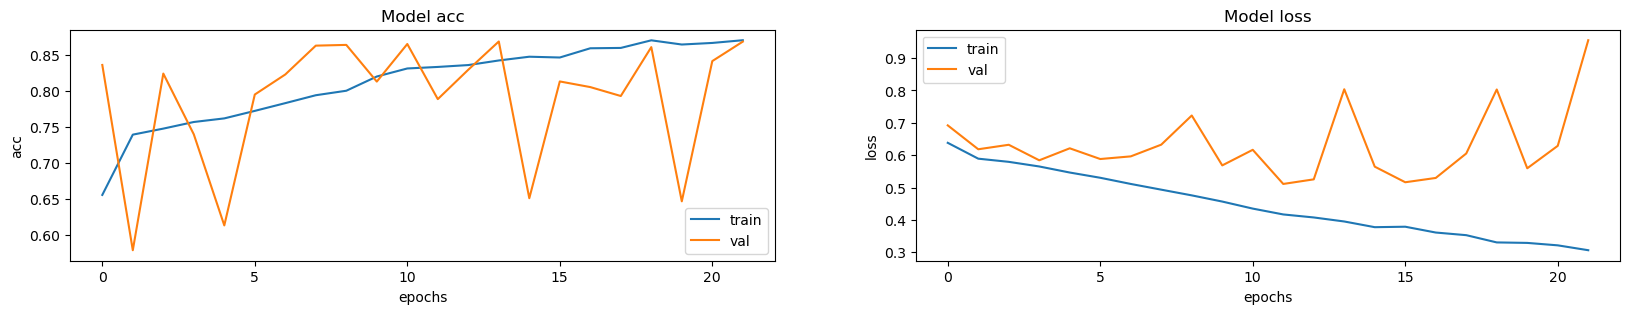

In [169]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    


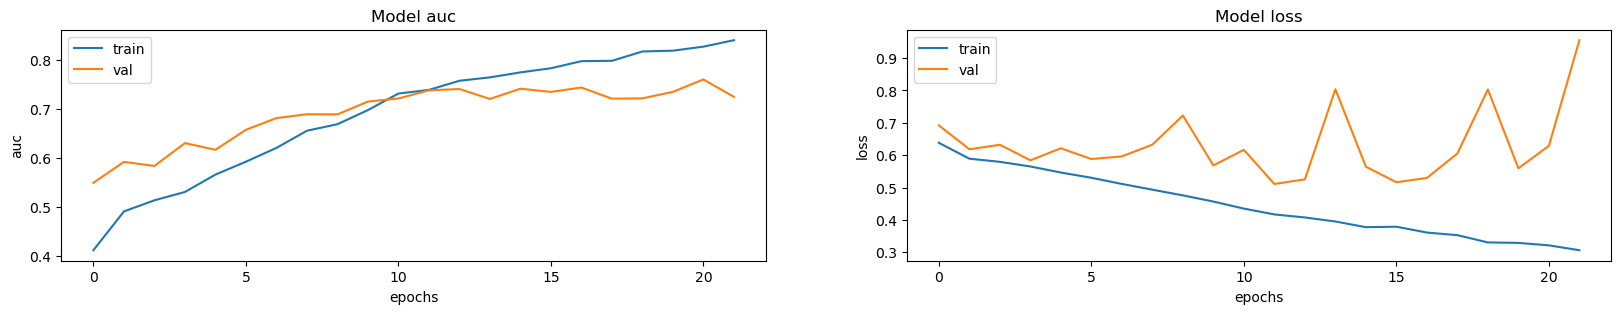

In [170]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [136]:
#model.load_weights("checkpoint_dir/20230801-030754KERAS_Bi_LSTM_batch128_LSTM128_DROP06_LSTM64_DROP05/M_0_restored_weight_cp.ckpt")

In [171]:
model.evaluate(X_test, y_test) 


152/152 [==============================] - 3s 21ms/step - loss: 0.5411 - fbeta_score: 0.6457 - auc: 0.6891 - acc: 0.7683


[0.5410593748092651, 0.6456584930419922, 0.689098060131073, 0.7682976722717285]

In [172]:
pred = model.predict(X_test)
print(pred)

152/152 [==============================] - 3s 19ms/step
[[0.5389227 ]
 [0.6431897 ]
 [0.26519856]
 ...
 [0.06108606]
 [0.09159313]
 [0.16574816]]


In [173]:
print(pred)

[[0.5389227 ]
 [0.6431897 ]
 [0.26519856]
 ...
 [0.06108606]
 [0.09159313]
 [0.16574816]]


In [174]:
"""
paths=[]
paths.append("checkpoint_dir/20230805-191811bnrelu_model/M_0_restored_weight_cp.ckpt")
paths.append("checkpoint_dir/20230805-191811bnrelu_model/M_1_restored_weight_cp.ckpt")



preds=[]



for i in range(len(paths)):
    model.load_weights(paths[i])    
    print("Résultats modèle ",i," : ")
    model.evaluate(X_val,y_val)
    model.evaluate(X_test,y_test)
    preds.append(model.predict(X_test,verbose=0))"""

'\npaths=[]\npaths.append("checkpoint_dir/20230805-191811bnrelu_model/M_0_restored_weight_cp.ckpt")\npaths.append("checkpoint_dir/20230805-191811bnrelu_model/M_1_restored_weight_cp.ckpt")\n\n\n\npreds=[]\n\n\n\nfor i in range(len(paths)):\n    model.load_weights(paths[i])    \n    print("Résultats modèle ",i," : ")\n    model.evaluate(X_val,y_val)\n    model.evaluate(X_test,y_test)\n    preds.append(model.predict(X_test,verbose=0))'

In [175]:
mean,maj = get_mean_maj_preds(pred,df_test)
y_true = get_y_true(df_test)

In [176]:
print("Weighted accuracy score of majority_pred : ",compute_weight_acc(maj,get_y_true(df_test)))
print("Weighted accuracy score of mean_pred : ",compute_weight_acc(mean,get_y_true(df_test)))

Weighted accuracy score of majority_pred :  0.8454810495626822
Weighted accuracy score of mean_pred :  0.8454810495626822


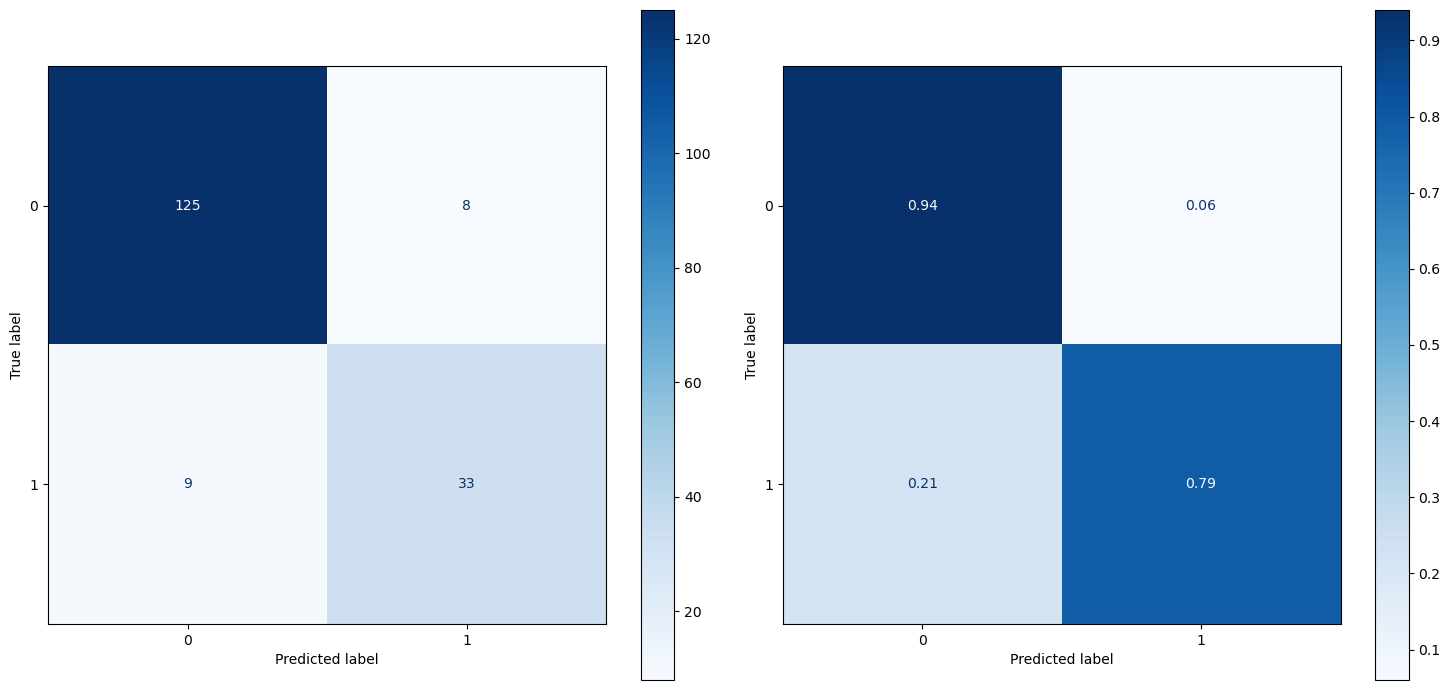

In [177]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))


ConfusionMatrixDisplay.from_predictions(y_true, maj,ax=axes[0],
                                        cmap='Blues', normalize = None)

ConfusionMatrixDisplay.from_predictions(y_true, maj,ax=axes[1],
                                        cmap='Blues', normalize = 'true')

plt.tight_layout()  
plt.show()

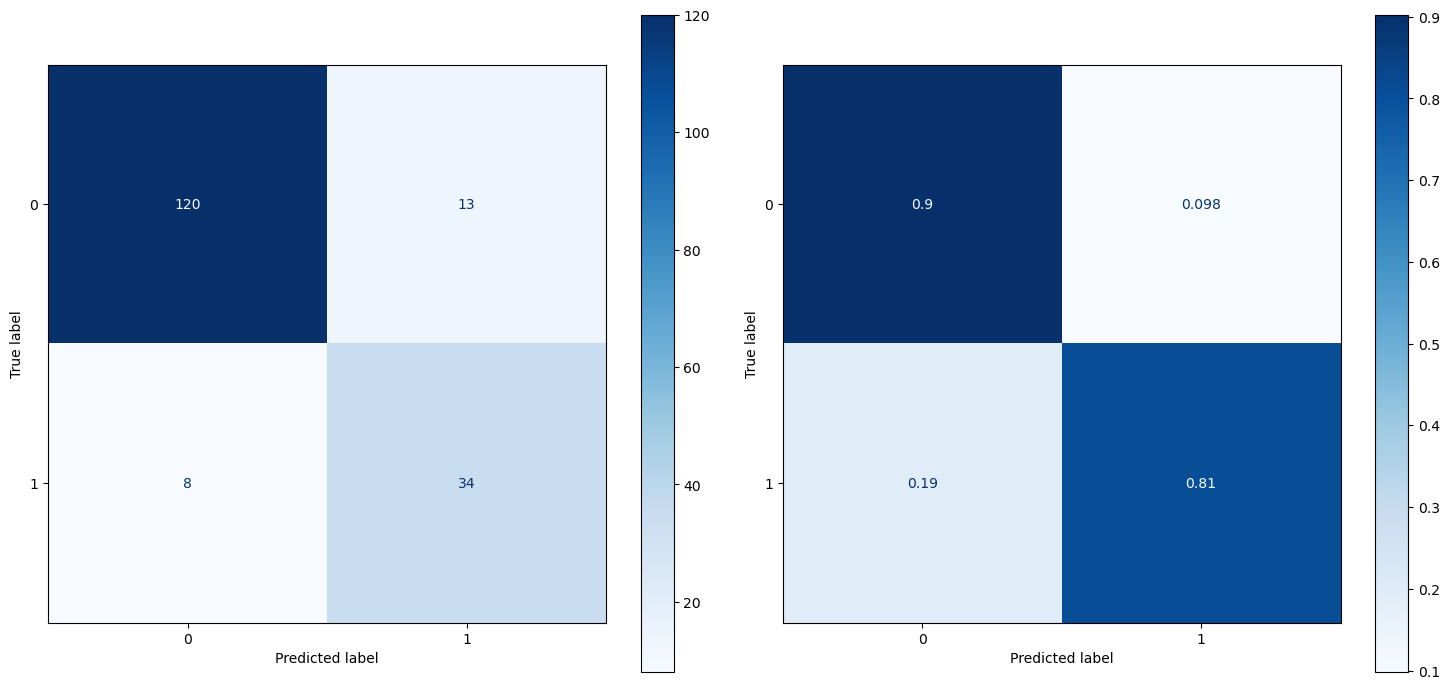

In [178]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))


ConfusionMatrixDisplay.from_predictions(y_true, mean,ax=axes[0],
                                        cmap='Blues', normalize = None)

ConfusionMatrixDisplay.from_predictions(y_true, mean,ax=axes[1],
                                        cmap='Blues', normalize = 'true')

plt.tight_layout()  
plt.show()

In [1]:
pred = [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]

In [ ]:
y_true = 